In [1]:
# ───────────────────────────────
# 📦 Standard Libraries
# ───────────────────────────────
import os
import sys
import math
import time
import csv
import pickle
from datetime import datetime, timedelta
from collections import Counter

# ───────────────────────────────
# 📚 Data Handling & Utilities
# ───────────────────────────────
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm
import h5py
from joblib import dump, load

# ───────────────────────────────
# 📊 Visualization
# ───────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ───────────────────────────────
# 📈 Machine Learning
# ───────────────────────────────
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_curve, roc_auc_score, auc,
    classification_report, confusion_matrix
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.under_sampling import RandomUnderSampler

# ───────────────────────────────
# 🌍 Seismology & Signal Processing
# ───────────────────────────────
import obspy
from obspy import UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
from obspy.signal.filter import envelope
from scipy import stats, signal

# ───────────────────────────────
# 🔗 External Tools
# ───────────────────────────────
from zenodo_get import zenodo_get

# ───────────────────────────────
# 🤖 Deep Learning
# ───────────────────────────────
import torch
import torch.nn.functional as F


# ───────────────────────────────
# 🛠 Custom Utilities
# ───────────────────────────────
sys.path.insert(0, '/home/ak287/PNW_Seismic_Event_Classification/deep_learning/scripts')
from neural_network_architectures import SeismicCNN_2d

from utils import (
    extract_waveforms,
    compute_spectrogram,
    normalize_spectrogram_minmax,
    return_train_val_loaders,
    plot_confusion_matrix_and_cr,
    train_model,
    WaveformPreprocessor
)

# Pandas display options
pd.set_option('display.max_columns', None)


sys.path.append('/home/ak287/seisbench/seisbench/models')
import seisbench.models as sbm



# for extracting unique stations
import re
from pathlib import Path

cuda


In [2]:
# Function to extract information
def extract_datetime_info(date_str):
    date_obj = datetime.strptime(date_str, '%Y_%m_%d %H%M%S')
    hour_of_day = date_obj.hour - 8
    day_of_week = date_obj.weekday()  # Full day name
    month_of_year = date_obj.month  # Full month name
    return hour_of_day, day_of_week, month_of_year



def conv_to_datetime(df):
    new_df = []
    for i in range(len(df)):
        year = int(df[i].split('_')[0])
        month = int(df[i].split('_')[1])
        day = int(df[i].split('_')[2].split(' ')[0])
        hour = int(df[i].split('_')[2].split(' ')[1][0:2])
        minute = int(df[i].split('_')[2].split(' ')[1][2:4])
        second = int(df[i].split('_')[2].split(' ')[1][4:])
        new_df.append(obspy.UTCDateTime(year, month, day, hour, minute, second))
        
    return np.array(new_df)

## Loading the older catalog. 

In [3]:
pd.set_option('display.max_columns', None)
cat_all_old = pd.read_csv('../../data/IRISExoticEventCatalog.txt', sep='|')
cat_old = cat_all_old.copy()
cat_old

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
2,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
3,100000.0,150000.0,65000.0,820000.0,186,"IRIS, NCEDC",NaN,2013_07_25 101727,186,690.0,760.0,640.0,NaN,NaN,NaN,2000.0,2100.0,1600.0,61.98450,0.00,-143.16830,1,4.000000e+10,NaN,NaN,NaN,NaN,500.0,False,NaN,NaN,500.0,False,NaN,NaN,NaN,Wrangell Mountains,4,NaN,NaN,NaN,NaN,NaN,NaN,2013_07_25 101456,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",61.97220,-143.14950,61.98450,-143.16830,NaN,rock and debris avalanche,Rock/ice/debris avalanches and slides,2600000.0,3900000.0,1800000.0
4,23400.0,NaN,NaN,NaN,147,IRIS,NaN,2019_05_13 144245,147,1240.0,NaN,NaN,NaN,NaN,NaN,4320.0,NaN,NaN,50.34480,0.00,-122.45110,1,NaN,NaN,NaN,NaN,NaN,391.0,True,NaN,NaN,301.0,True,NaN,NaN,NaN,Mount Joffre 1,5,NaN,NaN,NaN,NaN,NaN,NaN,2019_05_13 143955,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",50.36720,-122.41540,50.34480,-122.45110,NaN,"rock avalanche, debris flow",Rock/ice/debris avalanches and slides,1900000.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,NaN,NaN,NaN,NaN,185,Attachments below,NaN,2015_06_09 160558,185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.67199,NaN,10.72268,0,NaN,NaN,NaN,3.0,NaN,3.0,True,NaN,NaN,0.0,NaN,NaN,NaN,NaN,Gadria 3,5,27.0,NaN,NaN,1.7,NaN,NaN,2015_06_09 151558,"Coviello, V., Arattano, M., Comiti, F., Maccon...",NaN,NaN,NaN,NaN,6.3,debris flow,Lahar/debris flow/outburst flood,12600.0,NaN,NaN
241,310000.0,520000.0,200000.0,7900000.0,19,IRIS,NaN,2012_06_11 222652,19,2400.0,2500.0,2300.0,NaN,NaN,NaN,9300.0,9500.0,9100.0,58.79367,0.00,-137.44247,1,2.000000e+10,NaN,NaN,NaN,NaN,890.0,True,NaN,NaN,1000.0,False,NaN,NaN,NaN,Mount Lituya main,4,NaN,NaN,NaN,NaN,NaN,NaN,2012_06_11 222400,"Allstadt, Kate E., McVey, Brennah G., and Malo...",58.81626,-137.30032,58.79367,-137.44247,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,13000000.0,60000000.0,2800000.0
242,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,

## Loading the newer catalog. 

In [4]:
pd.set_option('display.max_columns', None)
cat_all_new = pd.read_csv('../../src/IRIS_DMC_esecEventsDb_updated.txt', sep='|')
cat_new = cat_all_new.copy()
cat_new

,areaSource,areaSourceHigh,areaSourceLow,areaTotal,associationId,datlocation,depth,endtime,eventid,h,hHigh,hLow,hfall,hfall_high,hfall_low,l,lHigh,lLow,latitude,locuncertKm,longitude,lppotential,mass,massHigh,massLow,maxdistvhfKm,maxdistvhfReached,maxdisthfKm,maxdisthfReached,maxdistipKm,maxdistipReached,maxdistlpKm,maxdistlpReached,maxdistinfraKm,maxdistinfraReached,infraDetected,name,otherdataquality1to5,peakDischarge,peakDischargeLow,peakDischargeHigh,peakFlowheight,peakFlowheightLow,peakFlowheightHigh,starttime,sources,toeLat,toeLon,topLat,topLon,upstreamDrainarea,type,subtype,volume,volumeHigh,volumeLow
0,NaN,NaN,NaN,NaN,22,IRIS,NaN,2007_07_25 010251,22,1860.0,NaN,NaN,NaN,NaN,NaN,5760.0,NaN,NaN,61.10249,0.00,-140.30550,1,1.080000e+11,NaN,NaN,NaN,NaN,1079.0,True,NaN,NaN,1100.0,False,NaN,NaN,NaN,Mount Steele 2,5,NaN,NaN,NaN,NaN,NaN,NaN,2007_07_25 005835,"Allstadt, Kate E., McVey, Brennah G., and Malo...",61.14054,-140.25324,61.10249,-140.30550,NaN,rock and ice avalanche,Rock/ice/debris avalanches and slides,54000000.0,80500000.0,27500000.0
1,100000.0,NaN,NaN,1600000.0,273,IRIS,NaN,2017_06_23 214249,273,1200.0,NaN,NaN,NaN,NaN,NaN,2600.0,NaN,NaN,32.07970,0.00,103.66280,1,NaN,NaN,NaN,NaN,NaN,591.0,False,NaN,NaN,591.0,False,NaN,NaN,NaN,"Xinmo Village, China",5,NaN,NaN,NaN,NaN,NaN,NaN,2017_06_23 213916,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,"rock slide, rock avalanche",Rock/ice/debris avalanches and slides,13000000.0,14000000.0,12000000.0
2,NaN,NaN,NaN,NaN,218,"RESIF, ETH, ORFEUS, LMU, BGR, IRIS, INGV",NaN,2017_08_23 093828,218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.29552,NaN,9.60190,0,NaN,NaN,NaN,NaN,NaN,246.0,False,NaN,NaN,0.0,NaN,NaN,NaN,NaN,"Piz Cengalo 4, Switzerland",1,NaN,NaN,NaN,NaN,NaN,NaN,2017_08_23 093617,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,landslide,Rock/ice/debris avalanches and slides,NaN,NaN,NaN
3,111000.0,NaN,NaN,1130000.0,127,IRIS,NaN,2017_07_22 205957,127,931.0,NaN,NaN,NaN,NaN,NaN,3730.0,NaN,NaN,60.07385,0.00,-139.84532,1,NaN,NaN,NaN,NaN,NaN,351.0,False,NaN,NaN,386.0,False,0.0,NaN,False,Lucia Glacier,4,NaN,NaN,NaN,NaN,NaN,NaN,2017_07_22 205630,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",60.06616,-139.90755,60.07385,-139.84532,NaN,rock avalanche,Rock/ice/debris avalanches and slides,3000000.0,4000000.0,2300000.0
4,NaN,NaN,NaN,10000000.0,285,IRIS,NaN,1997_12_26 070719,285,NaN,NaN,NaN,NaN,NaN,NaN,4000.0,NaN,NaN,16.70900,0.10,-62.17620,1,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,450.0,False,NaN,NaN,NaN,Montserrat,5,NaN,NaN,NaN,NaN,NaN,NaN,1997_12_26 070240,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",16.67530,-62.17620,16.70900,-62.17620,NaN,"debris avalanche, pyroclastic density current",Rock/ice/debris avalanches and slides,46000000.0,50000000.0,40000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,3500000.0,NaN,NaN,NaN,275,IRIS,NaN,2009_08_10 110853,275,1500.0,NaN,NaN,NaN,NaN,NaN,7200.0,7500.0,7000.0,23.22810,0.00,120.75170,1,NaN,NaN,NaN,NaN,NaN,208.0,True,NaN,NaN,277.0,False,NaN,NaN,NaN,"Butangbunasi, Taiwan",5,NaN,NaN,NaN,NaN,NaN,NaN,2009_08_10 110556,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",23.18310,120.77820,23.22810,120.75170,NaN,landslide,Rock/ice/debris avalanches and slides,83800000.0,NaN,NaN
315,NaN,NaN,NaN,NaN,319,"NCEDC, IRIS",NaN,2022_08_03 032337,319,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.39070,1.00,-122.18550,0,NaN,NaN,NaN,0.0,NaN,14.0,False,NaN,NaN,0.0,NaN,NaN,NaN,False,"Mud Creek, Mount Shasta",3,NaN,NaN,NaN,NaN,NaN,NaN,2022_08_03 012901,"Collins, E.A., Allstadt, K.E., Groult, C., Hib...",NaN,NaN,NaN,NaN,NaN,debris flow,Lahar/debris flow/outburst flood,NaN,NaN,NaN
316,130000.0,160000.0,84000.0,3000000.0,188,"IRIS, NCEDC",NaN,2010_07_09 073820,188,1800.0,1900.0,1600.0,NaN,NaN,NaN,7600.0,7900.0,7300.0,51.87130,0.00,-125.94340

## Testing the retrained models on new events

In [5]:
cat_test = cat_new.merge(
    cat_old.drop_duplicates(),        # just in case cat_old has duplicates
    how="left",
    indicator=True
).query('_merge == "left_only"') \
  .drop(columns='_merge')             # (_merge was just for filtering)



# 1️⃣  Build the sets once
ids_test = set(cat_test['eventid'])
ids_old  = set(cat_old['eventid'])

# 2️⃣  Find and display every overlapping ID
overlap = ids_test & ids_old
print(f"🔍  Overlap count: {len(overlap)}")
if overlap:
    print("Overlapping eventid(s):", sorted(overlap))

# 3️⃣  Option A – DROP the overlaps from cat_test
cat_test_clean = cat_test[~cat_test['eventid'].isin(overlap)].copy()

# ───────────────────────────────────────────────────────────────
# If you’d rather regenerate your split instead of dropping, do it
# here (e.g. re-sample from cat_new after excluding cat_old).
# ───────────────────────────────────────────────────────────────

# 4️⃣  Final safety check
assert not cat_test_clean['eventid'].isin(cat_old['eventid']).any(), \
       "Overlap still present!"

print("✅  cat_test is now disjoint from cat_old.")

cat = cat_test_clean.copy()

🔍  Overlap count: 6
Overlapping eventid(s): [4, 23, 59, 81, 166, 192]
✅  cat_test is now disjoint from cat_old.


In [6]:
event_ids = cat['eventid'].values
source_types = cat['type'].values
source_subtypes = cat['subtype'].values

In [7]:
hod = [extract_datetime_info(i)[0] for i in cat['starttime'].values]
dow = [extract_datetime_info(i)[1] for i in cat['starttime'].values]
moy = [extract_datetime_info(i)[2] for i in cat['starttime'].values]

In [11]:
cat['starttime']

1      2017_06_23 213916
4      1997_12_26 070240
6      2013_01_21 010828
18     2020_07_24 214125
28     2021_07_27 172215
             ...        
296    2022_09_01 204553
306    2023_09_16 123545
312    2022_09_01 205421
314    2009_08_10 110556
315    2022_08_03 012901
Name: starttime, Length: 74, dtype: object

In [14]:
cat = cat.reset_index(drop = True)
## computing the durations
sttime = cat['starttime']
ettime = cat['endtime']

starttimes = conv_to_datetime(sttime)
endtimes = conv_to_datetime(ettime)
dur = conv_to_datetime(ettime) - conv_to_datetime(sttime)

In [16]:
st_z = []
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
event_types = []
event_subtypes = []
event_duration = []
trids = []


for i in tqdm(range(len(event_ids))):
    try:
        files = glob("../../data/iris_esec_waveforms/waveforms/"+str(event_ids[i])+'/*HZ*')
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type = 'linear')
            d = tr[0].resample(100).data
            
            ## We are going to test the ml_40 model (so we will use P-10, P+30)
            data = d[8500:12500]
            snr = np.nanmax(abs(data))/np.nanmean(abs(data))

            if snr > 5:
                st_data.append(data)
                evids.append(event_ids[i])           
                trids.append(tr[0].id)
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])
                
    except:
        pass
    

100%|██████████| 74/74 [00:07<00:00, 10.23it/s]


## Loading the trained model

In [25]:
## setting up some important parameters (not to be changed)
num_channels = 3
dropout = 0.9
# Check if a GPU is available
device = "cuda"



model_quakexnet_2d = SeismicCNN_2d(num_classes=4, num_channels=num_channels,dropout_rate=dropout).to(device)  # Use 'cuda' if you have a GPU available

# Load the saved model state dict (weights)
saved_model_quakexnet_2d = torch.load('../trained_models/best_model_new_augmented_esec_SeismicCNN_2d.pth', map_location=torch.device('cpu'))  # No 'weights_only' argument
model_quakexnet_2d.load_state_dict(saved_model_quakexnet_2d)
model_quakexnet_2d.to(device)
model_quakexnet_2d.eval()


model = model_quakexnet_2d
model.to('cuda')

SeismicCNN_2d(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=15360, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.9, inplace=False)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2_bn): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

## just loading the data

In [26]:
st_data = []
evids = []
hod_trace = []
dow_trace = []
moy_trace = []
snr_trace_z = []
event_types = []
event_subtypes = []
event_duration = []
trids = []

for i in tqdm(range(len(event_ids))):
    try:
        
        # Find all three-component waveforms for this event
        files = glob(f"../../data/iris_esec_waveforms/waveforms/{event_ids[i]}/*H*")
        
        
        # Dictionary to group traces by station
        station_data = {}

        
        for file in files:
            tr = obspy.read(file)
            tr = tr.detrend(type='linear')
            d = tr[0].resample(50).data
            
            data = d[:13500]  # Extract P-10 to P+30 (assuming 50 Hz sampling)
            snr = np.nanmax(abs(data)) / np.nanmean(abs(data))

            if snr > 1:
                station = tr[0].stats.station
                channel = tr[0].stats.channel
                key = (event_ids[i], station)  # Group by event and station
                
                if key not in station_data:
                    station_data[key] = {}

                station_data[key][channel] = data  # Store by channel

        # Process each station
        for key, traces in station_data.items():
            if len(traces) == 3:  # Ensure three-component data exists
                sorted_channels = sorted(traces.keys())  # Ensure order is consistent
                stacked_data = np.stack([traces[ch] for ch in sorted_channels])  # Shape (3, 4000)

                st_data.append(stacked_data)  # Append in shape (3, 4000)
                evids.append(key[0])  # Event ID
                trids.append(key[1])  # Station ID
                hod_trace.append(hod[i])
                dow_trace.append(dow[i])
                moy_trace.append(moy[i])
                
                event_types.append(source_types[i])
                event_subtypes.append(source_subtypes[i])
                event_duration.append(dur[i])

    except Exception as e:
        print(f"Error processing event {event_ids[i]}: {e}")
        continue

# Convert to NumPy array
st_data = np.array(st_data)  # Final shape: (num_events, 3, 4000)


100%|██████████| 74/74 [00:16<00:00,  4.43it/s]


In [27]:
st_data.shape

(1143, 3, 13500)

In [28]:
#model1 = sbm.QuakeXNetoneD.from_pretrained("base")
model2 = sbm.SeismicCNN.from_pretrained("base")

In [29]:
probs_global = {}

for event_id in tqdm(event_ids):
    file_list = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*')
    
    # Extract unique station codes
    station_codes = set()
    for f in file_list:
        fname = Path(f).name
        match = re.match(r"[A-Z0-9]+\.(\w+)", fname)
        if match:
            station_codes.add(match.group(1))

    stn_list = sorted(station_codes)
    
    for stn in stn_list:
        chn_list = glob(f'../../data/iris_esec_waveforms/waveforms/{event_id}/*{stn}*')

        # Continue only if exactly 3 components are found
        if len(chn_list) == 3:
            try:
                st = obspy.Stream()
                for chn in chn_list:
                    st += obspy.read(chn)
                
                # Optional: sort channels to ensure consistent order
                st.sort(['channel'])
                
                # Predict probabilities using model
                probs_windows = np.array(model2.annotate(st))
                
                # Store in dict
                probs_global[(event_id, stn)] = probs_windows

            except Exception as e:
                print(f"Error with event {event_id}, station {stn}: {e}")


100%|██████████| 74/74 [00:23<00:00,  3.21it/s]


In [30]:
probs_global

{(276,
  'BABIT'): array([[1.6647812e-02, 4.3889545e-06, 8.2580600e-06, 4.2224286e-07],
        [7.7182474e-03, 1.4385409e-03, 1.6077188e-06, 1.0141771e-06],
        [4.7506347e-01, 6.7689168e-01, 9.9996865e-01, 9.9268508e-01],
        [5.0057048e-01, 3.2166544e-01, 2.1435311e-05, 7.3134569e-03]],
       dtype=float32),
 (276,
  'BARN'): array([[4.6127102e-06, 8.1435159e-10, 4.2118091e-02, 9.6677434e-01],
        [2.9617592e-04, 2.8221830e-04, 2.8783311e-03, 1.6041095e-06],
        [9.7324431e-01, 1.1449441e-04, 5.9446889e-01, 3.2259811e-02],
        [2.6454866e-02, 9.9960333e-01, 3.6053464e-01, 9.6430181e-04]],
       dtype=float32),
 (276,
  'LG2B'): array([[1.8158117e-01, 3.6293432e-07, 1.8439190e-01, 6.7875367e-01],
        [7.7563696e-02, 6.4254264e-06, 1.0391470e-01, 2.8287066e-04],
        [2.1835345e-01, 9.9998891e-01, 5.6919563e-01, 3.1115559e-01],
        [5.2250165e-01, 4.3084538e-06, 1.4249770e-01, 9.8078819e-03]],
       dtype=float32),
 (276,
  'PRCT'): array([[5.7595032e

In [31]:
def process_probabilities(probs_dict, threshold=0.5):
    rows = []
    for (event_id, station), prob_array in probs_dict.items():
        
        prob_eq = prob_array[0].max()
        prob_px = prob_array[1].max()
        prob_noise = prob_array[2].max()
        prob_su = prob_array[3].max()

        max_prob = max(prob_eq, prob_px, prob_su)
        if max_prob > threshold:
            if max_prob == prob_eq:
                label = 'eq'
            elif max_prob == prob_px:
                label = 'px'
            else:
                label = 'surface'
        else:
            label = 'noise'

        rows.append({
            'event_id': event_id,
            'station': station,
            'prob_eq': prob_eq,
            'prob_px': prob_px,
            'prob_noise': prob_noise,
            'prob_surface': prob_su,
            'max_prob': max_prob,
            'assigned_label': label
        })

    return pd.DataFrame(rows)


In [32]:
# Example usage:
labels_df = process_probabilities(probs_global)
labels_df.head()

,event_id,station,prob_eq,prob_px,prob_noise,prob_surface,max_prob,assigned_label
0,276,BABIT,0.016648,0.007718,0.999969,0.500570,0.500570,surface
1,276,BARN,0.966774,0.002878,0.973244,0.999603,0.999603,surface
2,276,LG2B,0.678754,0.103915,0.999989,0.522502,0.678754,eq
3,276,PRCT,0.536319,0.283497,0.990184,0.929660,0.929660,surface
4,276,U15A,0.000108,0.000148,0.999996,0.000351,0.000351,noise


<Axes: >

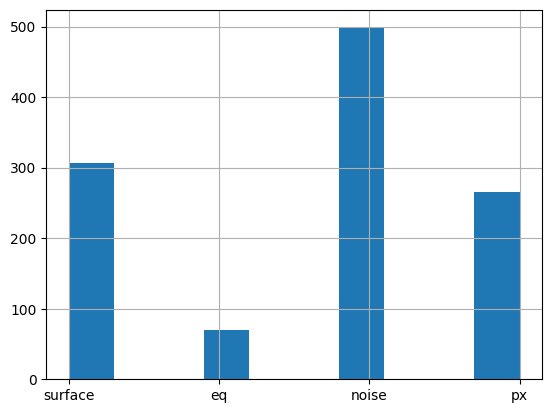

In [33]:
labels_df['assigned_label'].hist()